In [1]:
import os

from autofit import conf
from autofit.core import non_linear

from autolens.data.imaging import image as im
from autolens.data.imaging.plotters import imaging_plotters
from autolens.lensing.plotters import lensing_fitting_plotters
from autolens.model.galaxy import galaxy_model as gm
from autolens.model.profiles import light_profiles as lp
from autolens.model.profiles import mass_profiles as mp
from autolens.pipeline import phase as ph

path = os.path.dirname(os.path.realpath(__file__))

# In this example, we're going to take an image and find a lens model that provides a good fit to it and we're going 
# to do this without any knowledge of what the 'correct' lens model is. 

# So, what do I mean by a 'lens model'? The lens model is the combination of light profiles and mass profiles we use to 
# represent lens galaxy, source galaxy and therefore create a tracer. Thus, to begin, we have to choose the 
# parametrization of our lens model. We don't need to specify the values of its light and mass profiles (e.g. the
# centre, einstein_radius, etc.) - only the profiles are. In this example, we'll use the following lens model:

# 1) A spherical Isothermal Sphere (SIS) for the lens galaxy's mass.
# 2) A spherical exponential light profile for the source galaxy's light.

# I'll let you into a secret - this is the same lens model that I used to simulate the image we'll fit (but I'm not
# going to tell you the actual parameters I used!).

# So, how do we infer these parameters? Well, we could randomly guess a lens model, corresponding to some
# random set of parameters. We could use this lens model to create a tracer and fit the image-data, and quantify how
# good the fit was using its likelihood (we inspected this in previous tutorial). If we kept guessing lens
# models, eventually we'd find one that provides a good fit (i.e. high likelihood) to the data!

# It may sound nuts, but this is actually the basis of how lens modeling works. However, we do a lot better than
# random guessing. Instead, we track the likelihood of our previous guesses, and guess more models using combinations
# of parameters that gave higher likelihood solutions previously. The idea is that if a set of parameters provided a 
# good fit to the data, another set with similar values probably will too.

# This is called 'non-linear search' and its a fairly common analysis found in science. Over the next few tutorials, 
# we're going to really get our heads around the concept of a non-linear search - this intuition will prove crucial 
# in being a successful lens modeler.

# We're going to use a non-linear search called 'MultiNest'. I highly recommend it, and find its great for lens 
# modeling. However, for now, lets not worry about the details of how MultiNest actually works. Instead, just
# picture that a non-linear search in PyAutoLens operates as follows:

# 1) Randomly guess a lens model and use its light-profiles and mass-profiles to set up a lens galaxy, source galaxy 
#    and a tracer.

# 2) Pass this tracer through the fitting module, generating a model image and comparing this model image to the
#    observed strong lens imaging data. This means that we've computed a likelihood.

# 3) Repeat this many times, using the likelihoods of previous fits (typically those with a high likelihood) to
#    guide us to the lens models with the highest liikelihood.

In [2]:
# You're going to see a line like the one below (with 'conf.instance') in every tutorial this chapter. I recommend that 
# for now you just ignore it. A non-linear search can take a long time to run (minutes, hours, or days), and this
#  isn't ideal if you want to go through the tutorials without having to constant stop for long periods!

# This line overrides the configuration of the non-linear search such that it computes the solution really fast. To
# do this, I've 'cheated' - I've computed the solution myself and then input it into the config. Nevertheless, it means
# things will run fast for you, meaning you won't suffer long delays doin the tutorials.
#
# This will all become clear at the end of the chapter, so for now just bare in mind that we are taking a short-cut
# to get our non-linear search to run fast!

# If you are using Docker, the paths to the chapter is as follows (e.g. comment out this line)!
# path = '/home/user/workspace/howtolens/chapter_2_lens_modeling'

# If you arn't using docker, you need to change the path below to the chapter 2 directory and uncomment it
# path = '/path/to/user/workspace/howtolens/chapter_2_lens_modeling'
conf.instance = conf.Config(config_path=path+'/configs/1_non_linear_search', output_path=path+"/output")


In [4]:
# This function simulates the image we'll fit in this tutorial.
def simulate():

    from autolens.data.array import grids
    from autolens.model.galaxy import galaxy as g
    from autolens.lensing import ray_tracing

    psf = im.PSF.simulate_as_gaussian(shape=(11, 11), sigma=0.1, pixel_scale=0.1)

    image_plane_grids = grids.DataGrids.grids_for_simulation(shape=(130, 130), pixel_scale=0.1, psf_shape=(11, 11))

    lens_galaxy = g.Galaxy(mass=mp.SphericalIsothermal(centre=(0.0, 0.0), einstein_radius=1.6))
    source_galaxy = g.Galaxy(light=lp.SphericalExponential(centre=(0.0, 0.0), intensity=0.2, effective_radius=0.2))
    tracer = ray_tracing.TracerImageSourcePlanes(lens_galaxies=[lens_galaxy], source_galaxies=[source_galaxy],
                                                 image_plane_grids=[image_plane_grids])

    image_simulated = im.Image.simulate(array=tracer.image_plane_image_for_simulation, pixel_scale=0.1,
                                           exposure_time=300.0, psf=psf, background_sky_level=0.1, add_noise=True)

    return image_simulated


In [5]:
# and this calls the function, setting us up with an image to model. Lets plot it
image = simulate()
imaging_plotters.plot_image_subplot(image=image)

NoSectionError: No section: 'output'

In [6]:
# A GalaxyModel behaves analogously to the Galaxy objects we're now used to. However, whereas for a Galaxy we
# manually specified the value of every parameter of its light-profiles and mass-profiles, for a GalaxyModel
# these are inferred by the non-linear search.

# Lets model the lens galaxy with an SIS mass profile (which is what it was simulated with).
lens_galaxy_model = gm.GalaxyModel(mass=mp.SphericalIsothermal)

PriorException: The prior config at /path/to/user/workspace/howtolens/chapter_2_lens_modeling/configs/1_non_linear_search/priors/default/mass_profiles does not contain centre_0 in SphericalIsothermal or any of its parents

In [7]:
# Lets model the source galaxy with a spherical exponential light profile (again, what it was simulated with).
source_galaxy_model = gm.GalaxyModel(light=lp.SphericalExponential)

In [8]:
# A phase takes our galaxy models and fits their parameters via a non-linear search (in this case, MultiNest). In this
# example, we have a lens-plane and source-plane, so we use a LensSourcePlanePhase.

# (Just like we could give profiles descriptive names, like 'light', 'bulge' and 'disk', we can do the exact same
# thing with galaxies. This is very good practise - as once we start using complex lens models, you could potentially
# have a lot of galaxies - and this is the best way to keep track of them!)

# (also, just ignore the 'dict' - its necessary syntax but not something you need to concern yourself with)

phase = ph.LensSourcePlanePhase(lens_galaxies=dict(lens_galaxy=lens_galaxy_model),
                                source_galaxies=dict(source_galaxy=source_galaxy_model),
                                optimizer_class=non_linear.MultiNest,
                                phase_name='1_non_linear_search')

In [9]:
# To run the phase, we simply pass it the image data we want to fit, and the non-linear search begins! As the phase
# runs, a logger will show you the parameters of the best-fit model.
print('MultiNest has begun running - checkout the workspace/howtolens/chapter_2_lens_modeling/output/1_non_linear_search'
      'folder for live output of the results, images and lens model.'
      'This Jupyter notebook cell with progress once MultiNest has completed - this could take some time!')
results = phase.run(image)
print('MultiNest has finished run - you may now continue the notebook.')

/home/jammy/PyCharm/Projects/AutoLens/workspace/howtolens/chapter_2_lens_modeling/output/1_non_linear_search/optimizer/multinest.txt
Removed no burn in


In [10]:
# Now this has run you should checkout the 'AutoLens/output/workspace/howtolens' folder. This is where the results of the phase 
# are written to your hard-disk (in the '1_non_linear_search' folder). When its completed, images and output will also 
# appear in this folder, meaning that you don't need to keep running python code to see the results.

# We can print the results to see the best-fit model parameters
# print(results) # NOTE - this isn't working yet, need to sort out.

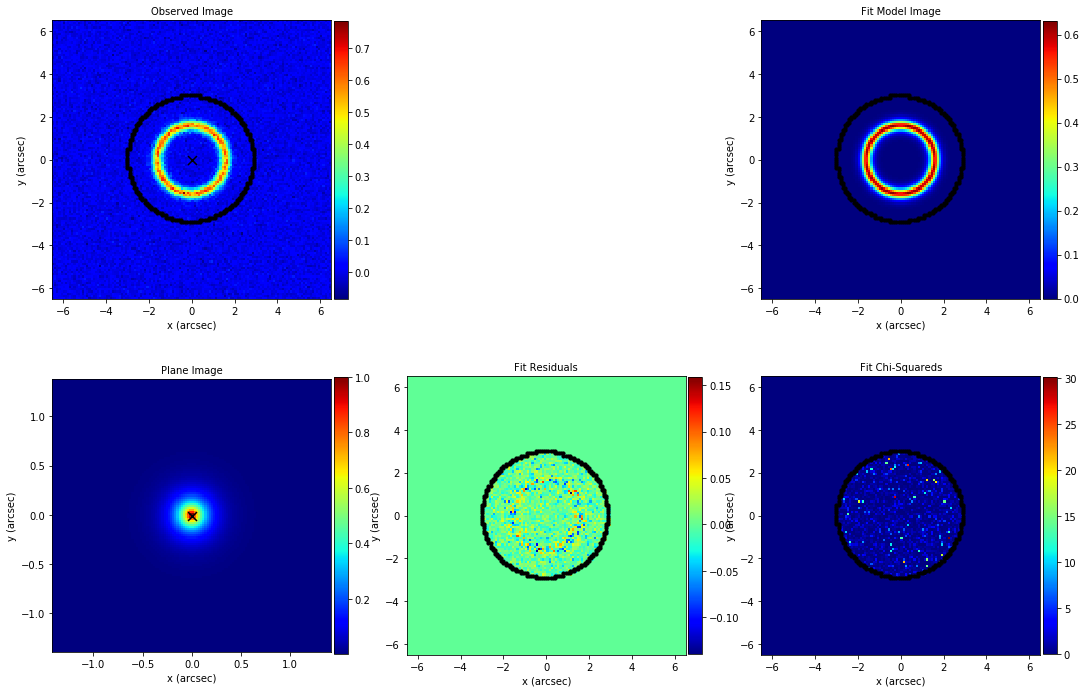

In [11]:
# The best-fit solution (i.e. the highest likelihood) is stored in the 'results', which we can plot as per usual.
lensing_fitting_plotters.plot_fitting_subplot(fit=results.fit)

In [15]:
# The fit looks good, and we've therefore found a model pretty close to the one we simulated the image with (you can 
# confirm this yourself if you want, by comparing the inferred parameters to those found in the simulations.py file).

# And with that, we're done - you've successfully modeled your first strong lens with PyAutoLens! Before moving
# onto the next tutorial, I want you to think about the following:

# 1) a non-linear search is often said to search a 'non-linear parameter-space' - why is the term parameter-space used?

# 2) Why is this parameter space 'non-linear'?

# 3) Initially, the non-linear search randomly guesses the values of the parameters. However, it shouldn't 'know' what
#    reasonable values for a parameter are. For example, it doesn't know that a reasonable Einstein radius is between 
#    0.0" and 4.0"). How does it know what are reasonable values of parameters to guess?